# The Forest Fire Model

## A rapid introduction to Mesa



The [Forest Fire Model](http://en.wikipedia.org/wiki/Forest-fire_model) is one of the simplest examples of a model that exhibits self-organized criticality.



Mesa is a new, Pythonic agent-based modeling framework. A big advantage of using Python is that it a great language for interactive data analysis. Unlike some other ABM frameworks, with Mesa you can write a model, run it, and analyze it all in the same environment. (You don't have to, of course. But you can).



In this notebook, we'll go over a rapid-fire (pun intended, sorry) introduction to building and analyzing a model with Mesa.

In [1]:
!pip install --quiet mesa

First, some imports. We'll go over what all the Mesa ones mean just below.

In [2]:
import numpy as np
import pandas as pd
from plotnine import *

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

## Building the model

Most models consist of basically two things: agents, and an world for the agents to be in. The Forest Fire model has only one kind of agent: a tree. A tree can either be unburned, on fire, or already burned. The environment is a grid, where each cell can either be empty or contain a tree.

First, let's define our tree agent. The agent needs to be assigned a cell on the grid, and that's about it. We could assign agents a condition to be in, but for now let's have them all start as being 'Fine'. We use `Agent` as the parent class.

Next, we define the agent's **step** method. This gets called whenever the agent needs to act in the world. The tree's behavior is simple: If it is currently on fire, it spreads the fire to any neighboring trees that are not burning or have not burned down.

In [3]:
class TreeCell(Agent):
    """
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.  
    """
    def __init__(self, model, pos):
        """
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        """
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

Now we need to define the model object itself. The main thing the model needs is the grid, which the trees are placed on. We can choose different kinds of grids such as a von Neumann grid where any cell has 4 neighbors (left, right, top and bottom) or Moore grid where a cell has eigh neighbors.



The model also needs a few parameters: how large the grid is and what the density of trees on it will be. Density will be the key parameter we'll explore below.



Finally, we'll give the model a data collector. This is a Mesa object which collects and stores data on the model as it runs for later analysis.



The constructor needs to do a few things. It instantiates all the model-level variables and objects; it randomly places trees on the grid, based on the density parameter; and it starts the fire by setting all the trees on one edge of the grid (x=0) as being On "Fire".



Next, the model needs a **step** method. Like at the agent level, this method defines what happens every step of the model. We want to activate all the trees, one at a time; then we run the data collector, to count how many trees are currently on fire, burned out, or still fine. If there are no trees left on fire, we stop the model by setting its **running** property to False.

In [4]:
class ForestFire(Model):
    """
    Simple Forest Fire model.
    """
    def __init__(self, height, width, density):
        """
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        """

        super().__init__()
        
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=False)
        self.datacollector = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if self.random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
        self.datacollector.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

## Running the model



Let's create a model with a 100 x 100 grid, and a tree density of 0.6. Remember, ForestFire takes the arguments *height*, *width*, *density*.

In [5]:
fire = ForestFire(100, 100, 0.6)

To run the model until it's done (that is, until it sets its **running** property to False) just use the **run_model()** method. This is implemented in the Model parent object, so we didn't need to implement it above.

In [6]:
fire.run_model()

That's all there is to it!



But... so what? This code doesn't include a visualization, after all. 



Remember the data collector? Now we can put the data it collected into a pandas DataFrame:

In [7]:
df = fire.datacollector.get_model_vars_dataframe()

In [8]:
df

,Fine,On Fire,Burned Out
0,5844,63,115
1,5741,58,223
2,5651,52,319
3,5561,48,413
4,5502,40,480
...,...,...,...
92,1206,13,4803
93,1191,7,4824
94,1188,1,4833
95,1184,1,4837


And chart it, to see the dynamics.

In [9]:
df = df.reset_index()
dfmelt = pd.melt(df, id_vars = ["index"],
                 value_vars=["Fine", "On Fire", "Burned Out"], 
                 var_name='Categories', value_name='Population')
dfmelt

,index,Categories,Population
0,0,Fine,5844
1,1,Fine,5741
2,2,Fine,5651
3,3,Fine,5561
4,4,Fine,5502
...,...,...,...
286,92,Burned Out,4803
287,93,Burned Out,4824
288,94,Burned Out,4833
289,95,Burned Out,4837


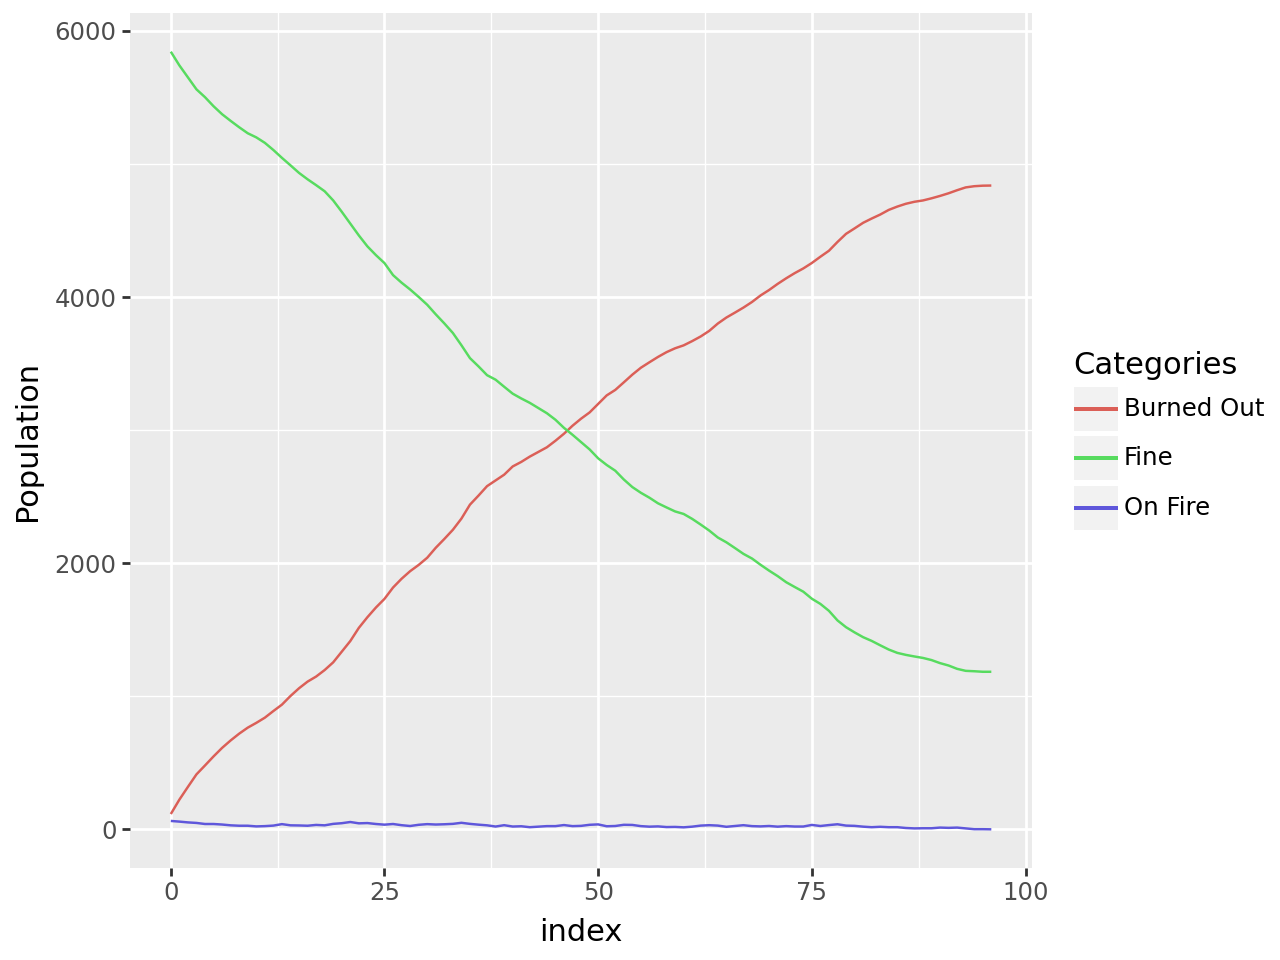

In [10]:
(
    ggplot(dfmelt, aes("index", "Population", color="Categories")) 
    + geom_line()
)

In this case, the fire burned itself out after about 90 steps, with many trees left unburned. 



You can try changing the density parameter and rerunning the code above, to see how different densities yield different dynamics. For example:

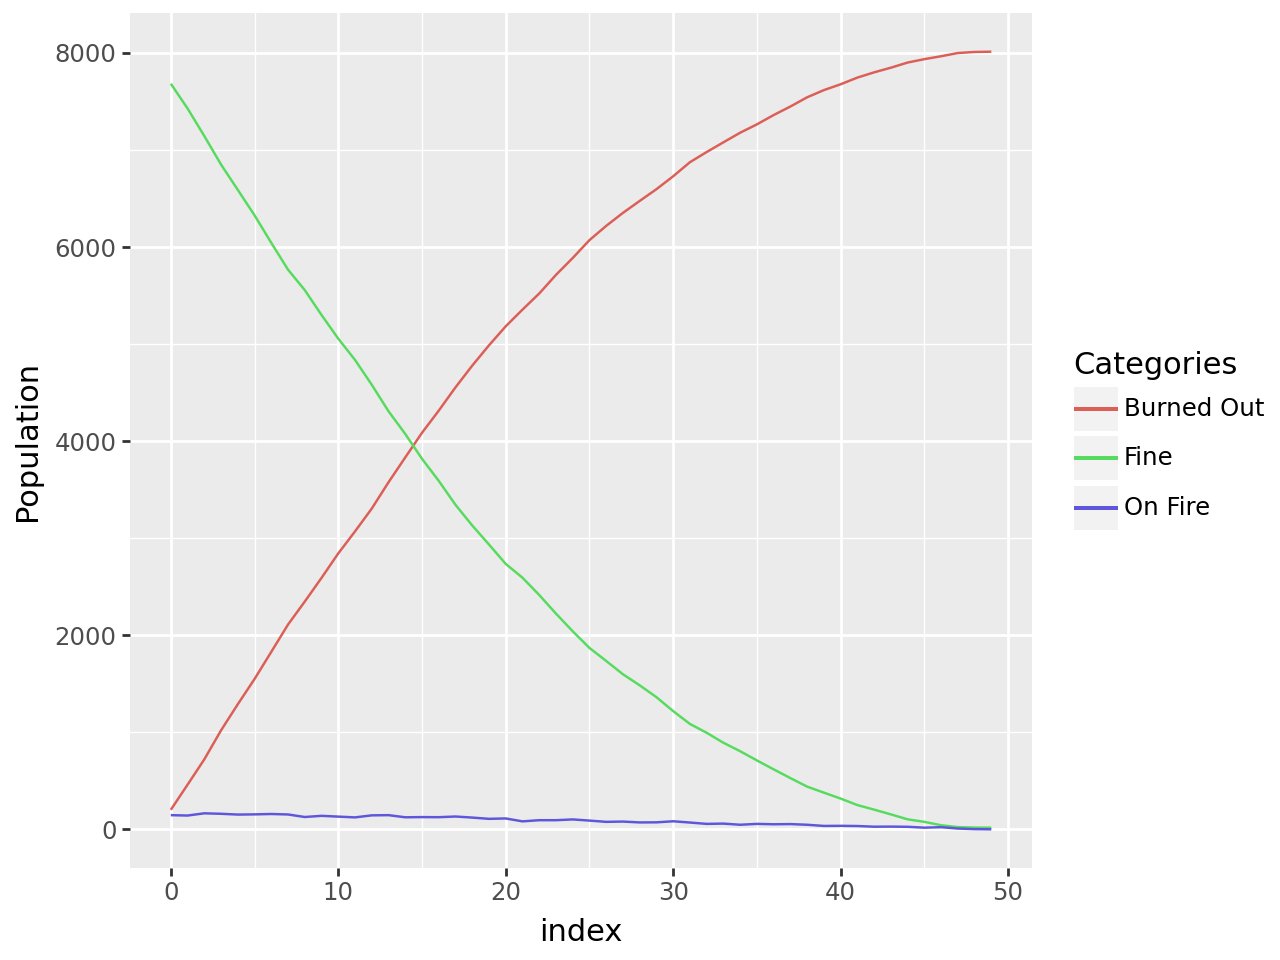

In [11]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()

df = fire.datacollector.get_model_vars_dataframe()
df = df.reset_index()
dfmelt = pd.melt(df, id_vars = ["index"],
                 value_vars=["Fine", "On Fire", "Burned Out"], 
                 var_name='Categories', value_name='Population')

(
    ggplot(dfmelt, aes("index", "Population", color="Categories")) 
    + geom_line()
)

... But to really understand how the final outcome varies with density, we can't just tweak the parameter by hand over and over again. We need to do a batch run. 

## Batch runs

Batch runs, also called parameter sweeps, allow us to systemically vary the density parameter, run the model, and check the output. Mesa provides a `batch_run` method which takes a model class, a dictionary of parameters and the range of values they can take and runs the model at each combination of these values. 

For ease of typing and reading, we'll first create the parameters to vary, and then call `batch_run`.

In [12]:
params = {"height": 50, "width": 50,  # Height and width are constant
        "density": np.linspace(0, 1, 101)[1:]} # Vary density from 0.01 to 1, in 0.01 increments:

In [13]:
# Run the batch runner

param_run = batch_run(
    ForestFire,
    parameters=params,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Now the results of all these runs are given in a list of dictionaries named named `param_run`, and we convert it to a DataFrame.

In [14]:
df = pd.DataFrame.from_records(param_run)
df

,RunId,iteration,Step,height,width,density,Fine,On Fire,Burned Out
0,0,0,0,50,50,0.01,26,0,0
1,1,0,0,50,50,0.02,48,0,0
2,2,0,0,50,50,0.03,70,0,3
3,3,0,0,50,50,0.04,96,0,0
4,4,0,0,50,50,0.05,132,0,1
...,...,...,...,...,...,...,...,...,...
95,95,0,19,50,50,0.96,0,0,2401
96,96,0,19,50,50,0.97,0,0,2420
97,97,0,19,50,50,0.98,0,0,2453
98,98,0,19,50,50,0.99,0,0,2474


We can calculate the burned percentage with a few new columns in our DataFrame.

In [15]:
df["num_agents"] = df["Fine"] + df["On Fire"] + df["Burned Out"]
df["burn_pct"] = df["Burned Out"] / df["num_agents"]

In [16]:
df

,RunId,iteration,Step,height,width,density,Fine,On Fire,Burned Out,num_agents,burn_pct
0,0,0,0,50,50,0.01,26,0,0,26,0.000000
1,1,0,0,50,50,0.02,48,0,0,48,0.000000
2,2,0,0,50,50,0.03,70,0,3,73,0.041096
3,3,0,0,50,50,0.04,96,0,0,96,0.000000
4,4,0,0,50,50,0.05,132,0,1,133,0.007519
...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,19,50,50,0.96,0,0,2401,2401,1.000000
96,96,0,19,50,50,0.97,0,0,2420,2420,1.000000
97,97,0,19,50,50,0.98,0,0,2453,2453,1.000000
98,98,0,19,50,50,0.99,0,0,2474,2474,1.000000


As you can see, each row here is a run of the model, identified by its parameter values (and given a unique index by the Run column). To view how the BurnedOut fraction varies with density, we can easily just plot them:

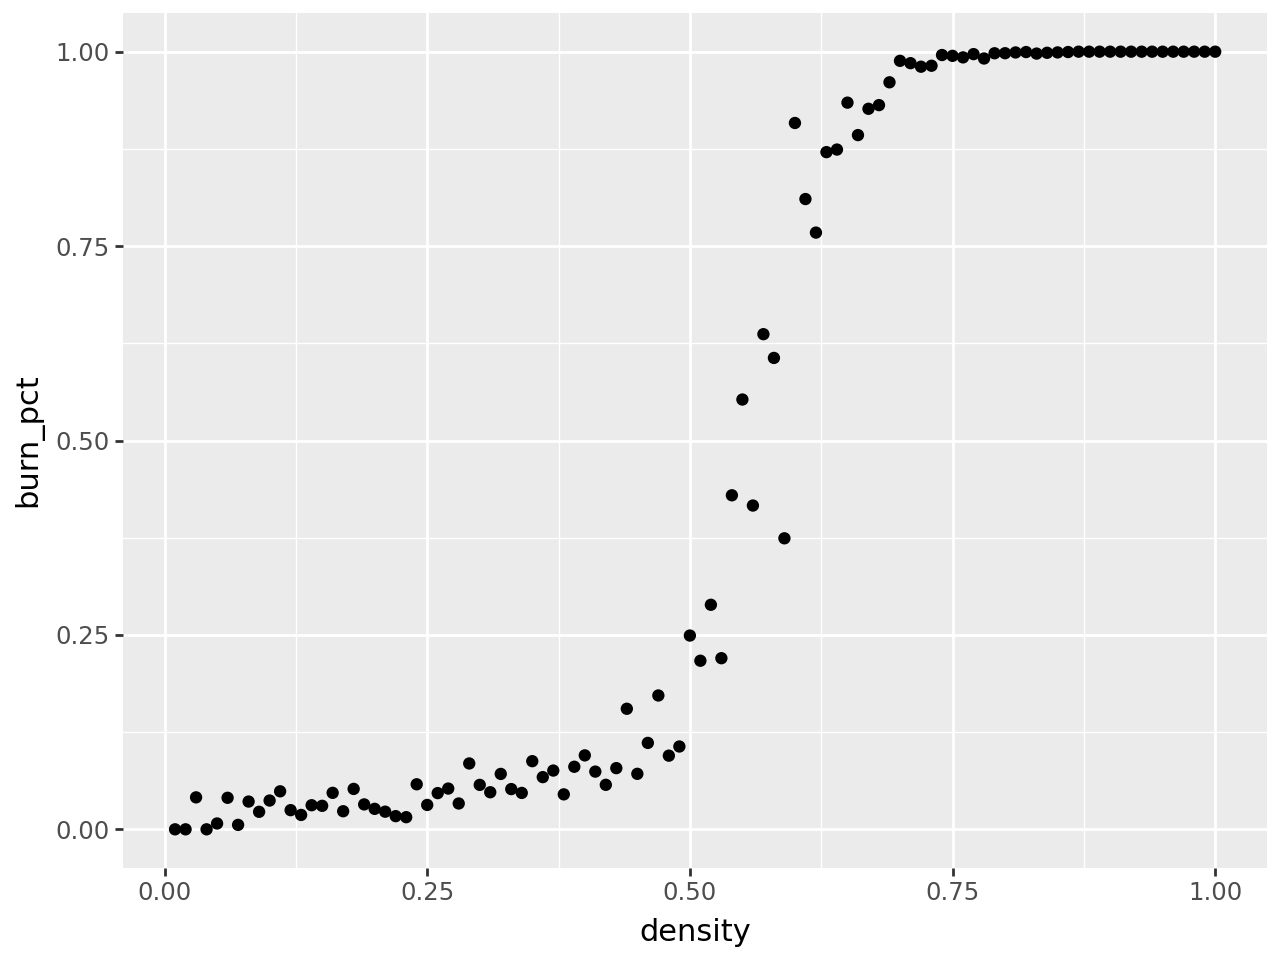

In [17]:
(
    ggplot(df, aes("density", "burn_pct")) 
    + geom_point()
)

And we see the very clear emergence of a critical value around 0.55, where the model quickly shifts from almost no trees being burned, to almost all of them.